In [2]:
import mlflow

In [12]:

from froodo.quickstart import *

import numpy as np
import torch


t = np.ones((3,4,4))
t[0, 1:3,1:3] = 0
t[1, 2:4,1:3] = 2
t[2, 0:2,1:3] = 0
print(np.mean(t, axis=(1,2)))
non_ignore = t == np.expand_dims(np.array([0,2,0]), list(range(1, t.ndim)))
t = np.ma.masked_array(t, non_ignore)
print(np.mean(t, axis=(1,2)))


[0.75 1.25 0.75]
[1.0 1.0 1.0]


In [22]:
import numpy as np

sample_intervals = [(0,1), (2,3), (6,8), (10,20)]

def sample_from_intervals(intervals):
    weights = np.array([i[1]-i[0] for i in intervals])
    interval_index = np.random.choice(list(range(len(intervals))),p=weights / weights.sum())
    return random.uniform(intervals[interval_index][0], intervals[interval_index][1])

for _ in range(10):
    print(sample_from_intervals(sample_intervals))




0.17423715230409142
2.081884673682371
14.132541247977645
16.334374448265358
12.299776643574155
11.856911697745112
0.6829796662798701
11.949012296593686
17.618128167358087
15.138200471796498


In [1]:
from froodo.quickstart import *

GeneralDatasetAdapter(BCSS_Adapted_Cropped_Resized_Datasets().test).adapter

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


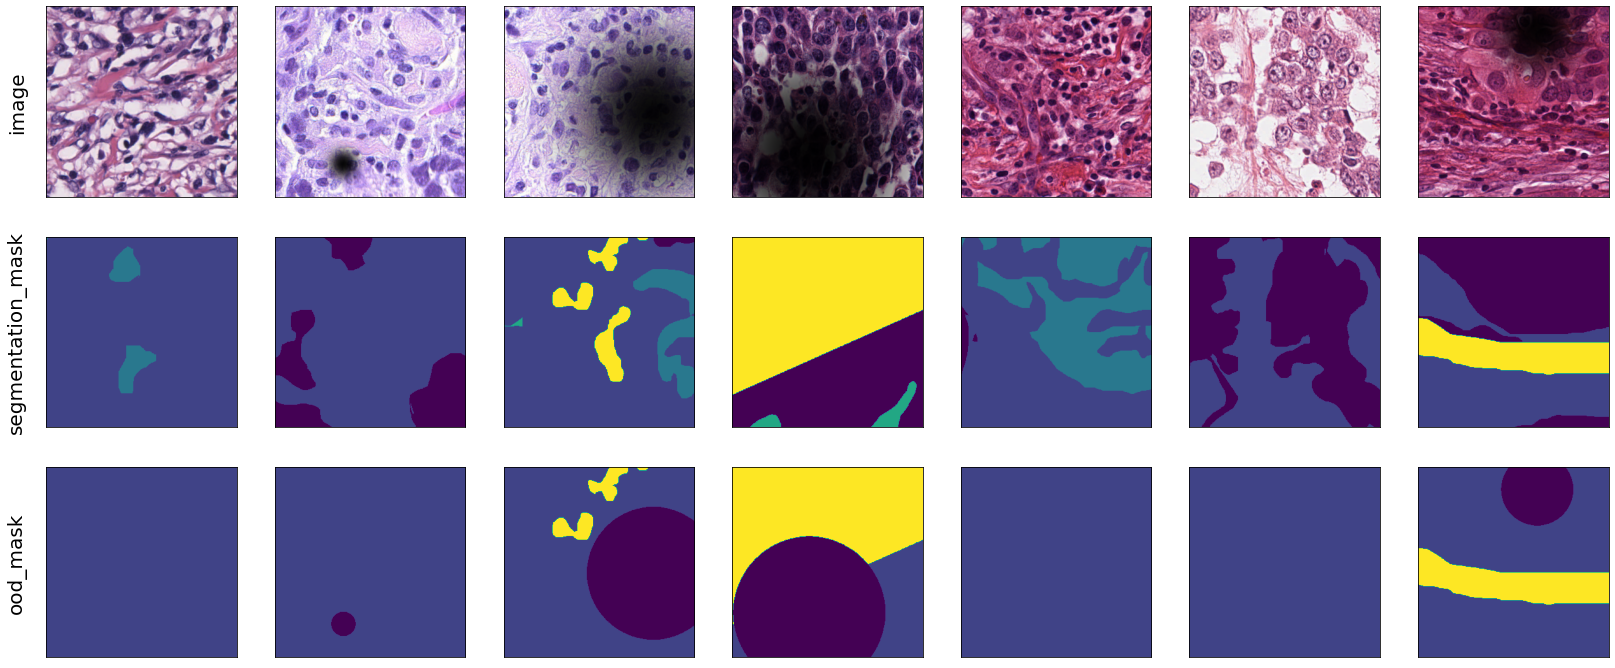

OOD Evaluation:   0%|          | 0/134 [00:00<?, ?it/s]c:\Users\jstieber\AppData\Local\conda\conda\envs\ssl4uc\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
OOD Evaluation: 100%|██████████| 134/134 [01:41<00:00,  1.32it/s]


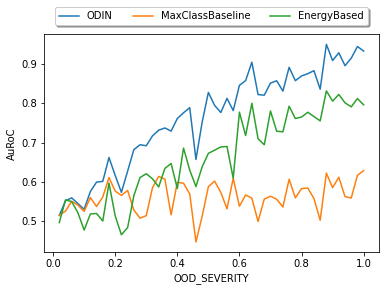

Name                             AUC
--------------------------  --------
ODIN temp: 2, noise: 0.004  0.73606
MaxClassBaseline no params  0.563295
EnergyBased temp: 1         0.645953


'\n\ncomponent = DatasetOODEvaluationComponent(\n    [BCSS_Adapted_Cropped_Resized_Datasets().val],\n    [BCSS_Adapted_Cropped_Resized_Datasets().test],\n    net,\n    seed=4321\n)\n\ncomponent()\n'

In [2]:
from froodo.models.segmentation import SegmentationModel
from froodo.data.datasets.examples.bcss import (
    BCSS_OOD_Dataset,
    BCSS_Base_Dataset,
    BCSS_Adapted_Datasets,
    BCSS_Adapted_Cropped_Resized_Datasets,
)
from froodo.data.datasets.interfaces import OODDataset
from froodo.ood.augmentations import *
from froodo.data.metadata import SampleMetadataCommonTypes
from froodo.data.container import MetadataContainer
from froodo.ood.metrics import OODAuRoC, infer_container
from froodo.ood.strategies import AugmentationStrategy, OODDatasetsStrategy
from froodo.ood.methods import ODIN, EnergyBased, MaxClassBaseline, TestOOD
from froodo.ood.augmentations.utility.pipeline import SizeInOODPipeline
from froodo.ood.augmentations.indistribution import InResize, InCrop
from froodo.experiment.components.examples import (
    AugmentationOODEvaluationComponent,
    DatasetOODEvaluationComponent,
)
from froodo.data.datasets.adapter import AlreadyASampleAdapter

import matplotlib.pyplot as plt
import tqdm
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, ConcatDataset


net = SegmentationModel().load()
metrics = [
    OODAuRoC(bin_by=SampleMetadataCommonTypes.OOD_SEVERITY.name, num_bins=50),
    OODAuRoC(),
]


component = AugmentationOODEvaluationComponent(
    BCSS_Adapted_Cropped_Resized_Datasets().test,
    SampledAugmentation(DarkSpotsAugmentation(keep_ignorred=False)),
    net,
    metrics=metrics,
    methods=[ODIN(), MaxClassBaseline(), EnergyBased()],
    seed=4321,
)


component()

"""

component = DatasetOODEvaluationComponent(
    [BCSS_Adapted_Cropped_Resized_Datasets().val],
    [BCSS_Adapted_Cropped_Resized_Datasets().test],
    net,
    seed=4321
)

component()
"""


In [ ]:
d = OODAugmentationDataset(
    # BCSS_Adapted_Cropped_Resized_Datasets().test,
    BCSS_Adapted_Datasets(size=(800, 800)).test,
    SizeInOODPipeline(
        size_augmentations=[OverlapAugmentation()],
        in_augmentations=[InCrop((600, 600)), InResize((300, 300))],
    ),
)

b = Batch.init_from_samples([d[0]])

print(b["ood_mask"])

non_ignore = b["ood_mask"] != torch.from_numpy(
    np.expand_dims(
        np.array(b.metadata["ignore_index"]),
        list(range(1, b["ood_mask"].ndim)),
    )
)
plt.imshow(non_ignore[0])
plt.show()
d[0].plot()

In [2]:
t = component.get_artifacts()["container"][0].container.metaframe
t

,type,ignore_index,OOD_SCORE.ODIN,OOD_SCORE.MaxClassBaseline,OOD_SCORE.TestOOD,OOD_SCORE.EnergyBased,OOD_SEVERITY,OOD_REASON,OOD_AUGMENTATION
0,DistributionSampleType.IN_DATA,5,0.851806,0.940348,-0.000018,3.800947,NaN,NaN,NaN
1,DistributionSampleType.OOD_DATA,5,0.801550,0.938279,-0.000017,3.666067,PixelPercentage [0-1]: 0.5462999939918518,OODReason.AUGMENTATION_OOD,<class 'frodo.ood.augmentations.pathology.arti...
2,DistributionSampleType.OOD_DATA,5,0.845599,0.942280,-0.000021,3.663401,PixelPercentage [0-1]: 0.11686666309833527,OODReason.AUGMENTATION_OOD,<class 'frodo.ood.augmentations.pathology.arti...
3,DistributionSampleType.IN_DATA,5,0.853499,0.926230,-0.000016,3.762583,NaN,NaN,NaN
4,DistributionSampleType.OOD_DATA,5,0.761902,0.947113,-0.000024,3.686467,PixelPercentage [0-1]: 0.9796000123023987,OODReason.AUGMENTATION_OOD,<class 'frodo.ood.augmentations.pathology.arti...
...,...,...,...,...,...,...,...,...,...
2136,DistributionSampleType.OOD_DATA,5,0.770162,0.937983,-0.000032,3.587814,PixelPercentage [0-1]: 0.6177555322647095,OODReason.AUGMENTATION_OOD,<class 'frodo.ood.augmentations.pathology.arti...
2137,DistributionSampleType.OOD_DATA,5,0.909761,0.925825,-0.000025,5.038090,PixelPercentage [0-1]: 0.04548889026045799,OODReason.AUGMENTATION_OOD,<class 'frodo.ood.augmentations.pathology.arti...
2138,DistributionSampleType.OOD_DATA,5,0.764679,0.944167,-0.000031,3.722176,PixelPercentage [0-1]: 0.9859889149665833,OODReason.AUGMENTATION_OOD,<class 'frodo.ood.augmentations.pathology.arti...
2139,DistributionSampleType.OOD_DATA,5,0.837996,0.921642,-0.000023,4.077877,PixelPercentage [0-1]: 0.3915555477142334,OODReason.AUGMENTATION_OOD,<class 'frodo.ood.augmentations.pathology.arti...


In [10]:
import pickle
data = pickle.load(open("filename.pickle", "rb"))

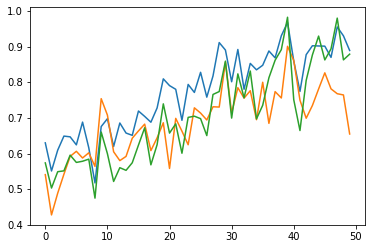

In [13]:
data.metric.present()

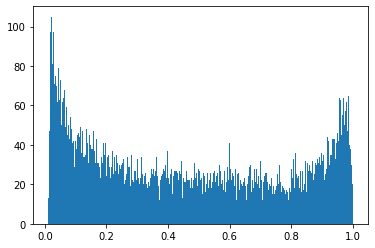

In [6]:
print(np.mean(score,tuple(range(1, score.ndim))))
all.extend(
[
    m["severity"].measurement
    for m in meta
    if m.type is DistributionSampleType.AUGMENTATION_OOD_DATA
] )

import numpy as np
plt.hist(all, 500)
plt.show()
